In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree



# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle

from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


from tqdm import tqdm

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
from src import soporte_ajuste as sa

In [3]:
df = pd.read_csv("datos/datos_preprocesados.csv",index_col=0)

In [4]:
df.head()

,price,size,municipality,distance,hasVideo,status,hasPlan,has3DTour,floor,hasLift,...,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,0.12,0.445948,-0.252799,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
1,750.0,0.52,0.038221,0.182949,1.0,0.0,1.0,0.0,-0.756628,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,590.0,0.52,-2.098184,2.118218,0.0,0.0,0.0,0.0,-1.114680,0.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Separamos la variable respuesta del resto de variables
X = df.drop(columns="price")
y = df[["price"]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)


In [7]:
np.set_printoptions(suppress= True)
# Establecemos un diccionario con los hiperparámetros
params_xg={    
    'n_estimators': [90,100,110],    #número de árboles que queremos que haga
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5,],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_leaf_nodes': [5, 6, 7, 8, 9]
}

In [8]:
modelo_xg= XGBRegressor(random_state=42, eval_metric= "rmse")
random_search_xg= GridSearchCV(modelo_xg,
                             params_xg,
                             cv=3,
                             scoring= "neg_mean_squared_error",
                             n_jobs=-1)

random_search_xg.fit(X_train,y_train["price"].values)   
modelo_final_xg= random_search_xg.best_estimator_
modelo_final_xg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaf_nodes=5,
             max_leaves=None, min_child_weight=None, min_samples_leaf=1,
             min_samples_split=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, ...)

In [9]:
y_pred_test = modelo_final_xg.predict(X_test)
y_pred_train = modelo_final_xg.predict(X_train)

In [10]:
df_metricas_xg = sa.metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_xg

,r2_score,MAE,MSE,RMSE
train,0.658097,22.782411,976.480091,31.248681
test,0.596399,29.411530,1295.948768,35.999288


Como en varios modelos anteriores tenemos overfitting, que empeoraría si bajamos el tamaño del train, pero aun así estás son las mejores métricas que hemos obtenido hasta ahora. con casi un 0,6 en r2 y 36 en RMSE.

Comparamos los precios predichos con los precios de los datos originales.

In [11]:
y_train.reset_index(inplace= True)
df_predicted = pd.DataFrame(y_pred_train)
df_predicted.rename(columns = {0:"predicted"}, inplace=True)
df_precios = pd.concat([df_predicted, y_train], axis=1)
df_precios.drop(columns = "index", inplace= True)
df_precios.head(5)

,predicted,price
0,718.422485,750.0
1,704.769531,600.0
2,718.975220,700.0
3,726.779968,720.0
4,716.138977,715.0


Vamos a ver la importancia de cada variable y tal vez saquemos alguna conclusión para futuras mejoras del modelo

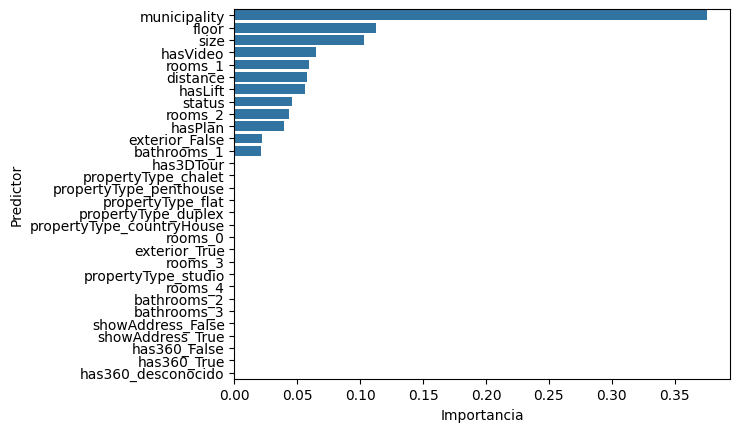

In [12]:
importancias = modelo_final_xg.feature_importances_
importancia_rf = pd.DataFrame({"Predictor": X_train.columns, "Importancia": importancias})
importancia_rf = importancia_rf.sort_values(by="Importancia", ascending=False)
sns.barplot(y = "Predictor", x = "Importancia", data = importancia_rf);

Tenemos muchas variables con importancia nula que eliminaremos en proximos modelos.